# Trajectory Descriptor Fields

# Setup
First, we clone the repository and install the local dependencies.

Make sure that you have enabled the GPU under Edit -> Notebook Settings!

In [ ]:
!git clone https://github.com/anthonysimeonov/ndf_robot.git
!pip install -r ndf_robot/requirements.txt

# Download local assets and set environment variables
We now download the necessary data and assets for running the demo. This includes a set of .obj 3D models of mugs that are saved in the folder `ndf_robot/src/ndf_robot/descriptions/demo_objects` and trained neural network weights for the [Occupancy Network](https://arxiv.org/abs/1812.03828) with the [Vector Neurons](https://arxiv.org/abs/2104.12229) layers in the folder `ndf/robot/src/ndf_robot/model_weights/ndf_demo_mug_weights.pth`. We also set the `NDF_SOURCE_DIR` environment variable.

In [ ]:
import sys
import os
sys.path.append('./ndf_robot/src')
os.environ['NDF_SOURCE_DIR'] = 'ndf_robot/src/ndf_robot'
!./ndf_robot/scripts/download_demo_weights.sh
!./ndf_robot/scripts/download_demo_data.sh

We then import all the necessary packages and library functions

In [ ]:
import os.path as osp
import torch
import numpy as np
import trimesh
import random
import copy
from scipy.spatial.transform import Rotation
from imageio import get_writer, imread

from ndf_robot.utils import path_util, torch_util, trimesh_util
import ndf_robot.model.vnn_occupancy_net_pointnet_dgcnn as vnn_occupancy_network
from ndf_robot.eval.ndf_alignment import NDFAlignmentCheck

# Load the object models
Here we obtain two of the mug object models we downloaded and load them into memory with `trimesh`. The .obj files had some trouble being visualized in the Colab so we hackily export them to .stl and reload them, which seems to help.

In [ ]:
class AttrDict(dict):
  __getattr__ = dict.__getitem__
  __setattr__ = dict.__setitem__

args = {
    'seed': 0,
    'show_recon': False,
    'sigma': 0.025,
    'visualize': True,
    'video': True
}
args = AttrDict(args)

seed = args.seed
np.random.seed(seed)
random.seed(seed)
torch.random.manual_seed(seed)

# see the demo object descriptions folder for other object models you can try
obj_model1 = osp.join(path_util.get_ndf_demo_obj_descriptions(), 'mug_centered_obj_normalized/28f1e7bc572a633cb9946438ed40eeb9/models/model_normalized.obj')
obj_model2 = osp.join(path_util.get_ndf_demo_obj_descriptions(), 'mug_centered_obj_normalized/586e67c53f181dc22adf8abaa25e0215/models/model_normalized.obj')

# colab has a weird thing showing the .obj versions of one of these models, so we quickly convert them to .stl files
mesh1 = trimesh.load(obj_model1, process=False); mesh1_stl = 'stl_model1.stl'; mesh1.export(mesh1_stl)
mesh2 = trimesh.load(obj_model2, process=False); mesh2_stl = 'stl_model2.stl'; mesh2.export(mesh2_stl)
model_path = osp.join(path_util.get_ndf_model_weights(), 'ndf_demo_mug_weights.pth')  

# Obtain point clouds from our two models
One of the models will act as the reference shape, and the other will be the test shape. They will have different uniform scalings applied to them (scaling the models up or down too much will lead to poor performance, as the network has not been trained on objects that are very large or small -- near 0.3 scaling is good for the ShapeNet objects we use).

Then we also apply a random rotation to the test mug to see how the SE(3)-equivariance of our descriptor field enables recovering a local coordinate frame that's consistent with the reference, even when the test mug is rotated.

Point clouds are obtained by uniformly sampling the surface of the mesh with the trimesh `sample` method.

In [ ]:
scale1 = 0.25
scale2 = 0.4
mesh1 = trimesh.load(mesh1_stl, process=False)
mesh1.apply_scale(scale1)
mesh2 = trimesh.load(mesh2_stl, process=False) # different instance, different scaling
mesh2.apply_scale(scale2)
# mesh2 = trimesh.load(mesh1_stl, process=False)  # use same object model to debug SE(3) equivariance
# mesh2.apply_scale(scale1)

# apply a random initial rotation to the new shape
quat = np.random.random(4)
quat = quat / np.linalg.norm(quat)
rot = np.eye(4)
rot[:-1, :-1] = Rotation.from_quat(quat).as_matrix()
mesh2.apply_transform(rot)

pcd1 = mesh1.sample(5000)
pcd2 = mesh2.sample(5000)  # point cloud representing different shape
# pcd2 = copy.deepcopy(pcd1)  # debug with the exact same point cloud
# pcd2 = mesh1.sample(5000)  # debug with same shape but different sampled points

show_mesh1 = mesh1.copy()
show_mesh2 = mesh2.copy()

offset = 0.2
show_mesh1.apply_translation([-1.0 * offset, 0, 0])
show_mesh2.apply_translation([offset, 0, 0])

scene = trimesh.Scene()
scene.add_geometry([show_mesh1, show_mesh2])
print('Showing demo shapes')
scene.show()

Showing demo shapes


# Set up the neural network and load the trained weights
Here we set up the occupancy network and load the trained weights. We use concatenate all the intermediate activations from the decoder of the occupancy network and use these as our descriptors, so we pass in `return_features=True` to retrieve these features. The weights we trained used [PointNet](https://arxiv.org/abs/1612.00593) with VN layers as the encoder, but the class also supports using [DGCNN](https://arxiv.org/abs/1801.07829), which we have not tried but it worth a shot to see how it compares to the PointNet encoder.

In [ ]:
model = vnn_occupancy_network.VNNOccNet(latent_dim=256, model_type='pointnet', return_features=True, sigmoid=True).cuda()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

# Energy optimization to recover local frame correspondence
We now run our demonstration of sampling a random local coordinate frame on the reference mug, and then recovering the pose of the corresponding local frame on the test shape. Obtaining the corresponding frame involves minimizing the descriptor distance to the local frame on the reference shape. 

This minimization is performed using SGD (Adam), by backpropagating gradients of the descriptor distance loss through the implicit representation to the SE(3) transformation that operates on the query point set. The optimization is somewhat sensitive to local minima so we run a batch in parallel from different initializations. The output of this cell shows the loss for each initialization, and the returned solution will be the one with the lowest final loss.

The code for this optimization is pretty simple, take a look here: 
https://github.com/anthonysimeonov/ndf_robot/blob/master/src/ndf_robot/eval/ndf_alignment.py#L115

In [ ]:
# take a look at the optimization process that runs in the sample_pts method to find frame correspondence here: 
# https://github.com/anthonysimeonov/ndf_robot/blob/master/src/ndf_robot/eval/ndf_alignment.py#L115
ndf_alignment = NDFAlignmentCheck(model, pcd1, pcd2, sigma=args.sigma, trimesh_viz=args.visualize)
scene = ndf_alignment.sample_pts(show_recon=args.show_recon, return_scene=True, render_video=args.video)

# Show results
Here we visualize the results of the frame correspondence. We plot both oriented point clouds. The blue mug is the reference and the red mug is the test shape. The query point set is shown with a coordinate frame attached at the middle, along with the path taken by centroid of the query point set during optimization. 

Take a look and see how the final position and orientation of the coordinate axis on the test mug is similar to the reference mug, despite the different mug instance, uniform scaling, and orientation. If you don't like the inline trimesh scene viewer, you can also open download and open the `visualization/best_alignment.html` file in a browser (see Files > `visualization/best_alignment.html` > Download)

In [ ]:
print('Showing lowest-cost point set/local frame correspondence')
scene.show()

Showing lowest-cost point set/local frame correspondence


# View animated optimization procedure
If you set `args.video` in the setup to be `True`, an image will be saved at each iteration of the optimization in the folder `vid_visualization` (warning -- this makes it take MUCH longer to run). After this is complete, you can run the below cells to stitch these into a video and view the animation.

In [ ]:
image_folder = ndf_alignment.video_viz_path
video_name = 'se3_optimization.mp4'

if args.video:
# assert args.video and len(os.listdir(image_folder)), 'Cannot render video!'
    assert len(os.listdir(image_folder)), 'Cannot render video!'
    import cv2

    images = [img for img in os.listdir(image_folder) if img.endswith(".png")]
    frame_idx = sorted([int(img.split('.png')[0].split('iter_')[1]) for img in images])
    frame = cv2.imread(osp.join(image_folder, images[0]))
    height, width, layers = frame.shape

    fps = 10
    writer = get_writer(video_name)

    for f_idx in frame_idx:
        image = osp.join(image_folder, 'opt_iter_%d.png' % f_idx)
        writer.append_data(imread(image))

    writer.close()

In [ ]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open(video_name,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()

In [ ]:
HTML("""
<video width=1200 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

# Under the hood - SE(3) transform optimization using NDFs
Here we will re-implement the core optimization code that is used to produce this^ visualized result (see https://github.com/anthonysimeonov/ndf_robot/blob/master/src/ndf_robot/eval/ndf_alignment.py), for anyone who wants to play around with different parameters (optimization parameters, query point size/shape, etc.).

Here we go!

We'll start with some extra imports and [`plotly`]() helper functions for visualization and showing a coordinate frame moving with our optimized query points.

In [ ]:
import plotly.graph_objects as go
from ndf_robot.utils import torch_util, trimesh_util
from ndf_robot.utils.plotly_save import plot3d


def cam_frame_scene_dict():
    cam_frame_scene_dict = {}
    cam_up_vec = [0, 1, 0]
    plotly_camera = {
        'up': {'x': cam_up_vec[0], 'y': cam_up_vec[1],'z': cam_up_vec[2]},
        'center': {'x': 0, 'y': 0, 'z': 0},
        'eye': {'x': -0.6, 'y': 0.6, 'z': 0.4},
    }

    plotly_scene = {
        'xaxis': 
            {
                'backgroundcolor': 'rgb(255, 255, 255)',
                'gridcolor': 'white',
                'zerolinecolor': 'white',
                'tickcolor': 'rgb(255, 255, 255)',
                'showticklabels': False,
                'showbackground': False,
                'showaxeslabels': False,
                'visible': False,
                'range': [-0.5, 0.5]},
        'yaxis': 
            {
                'backgroundcolor': 'rgb(255, 255, 255)',
                'gridcolor': 'white',
                'zerolinecolor': 'white',
                'tickcolor': 'rgb(255, 255, 255)',
                'showticklabels': False,
                'showbackground': False,
                'showaxeslabels': False,
                'visible': False,
                'range': [-0.5, 0.5]},
        'zaxis': 
            {
                'backgroundcolor': 'rgb(255, 255, 255)',
                'gridcolor': 'white',
                'zerolinecolor': 'white',
                'tickcolor': 'rgb(255, 255, 255)',
                'showticklabels': False,
                'showbackground': False,
                'showaxeslabels': False,
                'visible': False,
                'range': [-0.5, 0.5]},
    }
    cam_frame_scene_dict['camera'] = plotly_camera
    cam_frame_scene_dict['scene'] = plotly_scene
    return cam_frame_scene_dict

def plotly_create_local_frame(transform=None, length=0.03):
    if transform is None:
        transform = np.eye(4)

    x_vec = transform[:-1, 0] * length
    y_vec = transform[:-1, 1] * length
    z_vec = transform[:-1, 2] * length

    origin = transform[:-1, -1]

    lw = 8
    x_data = go.Scatter3d(
        x=[origin[0], x_vec[0] + origin[0]], y=[origin[1], x_vec[1] + origin[1]], z=[origin[2], x_vec[2] + origin[2]],
        line=dict(
            color='red',
            width=lw
        ),
        marker=dict(
            size=0.0
        )
    )
    y_data = go.Scatter3d(
        x=[origin[0], y_vec[0] + origin[0]], y=[origin[1], y_vec[1] + origin[1]], z=[origin[2], y_vec[2] + origin[2]],
        line=dict(
            color='green',
            width=lw
        ),
        marker=dict(
            size=0.0
        )
    )
    z_data = go.Scatter3d(
        x=[origin[0], z_vec[0] + origin[0]], y=[origin[1], z_vec[1] + origin[1]], z=[origin[2], z_vec[2] + origin[2]],
        line=dict(
            color='blue',
            width=lw
        ),
        marker=dict(
            size=0.0
        )
    )

    data = [x_data, y_data, z_data]
    return data


Then we set up the model and the file paths for where we'll save our visualized results. We also set up some additional optimization parameters like how many points are used from the point cloud, how many query points are used, and some noise parameters that help smooth out the optimization process. The `sigma` parameter is set at the beginning of the notebook, and adjusts the scale of the query point set.

In [ ]:
model_type = 'pointnet'
trimesh_viz = args.visualize
sigma = args.sigma

opt_iterations = 150
perturb_scale = 0.001
perturb_decay = 0.5
n_pts =  1500
n_opt_pts = 500

loss_fn = torch.nn.L1Loss()
if torch.cuda.is_available():
    dev = torch.device('cuda:0')
else:
    dev = torch.device('cpu')
model = model.to(dev)
model.eval()

viz_path = 'visualization'
if not osp.exists(viz_path):
    os.makedirs(viz_path)

video_viz_path = 'vid_visualization'
if not osp.exists(video_viz_path):
    os.makedirs(video_viz_path)

plotly_scene_dict = cam_frame_scene_dict()


Now we prepare our variables that are used in the optimization. We ensure the point cloud is centered at the origin, sample a random set of query points, and place it at a random location slightly beyond the shape. We then query our trained neural network that parameterizes the descriptor field to obtain a set of reference descriptors to try and match.

In [ ]:
pcd1 = pcd1 - np.mean(pcd1, axis=0)
pcd2 = pcd2 - np.mean(pcd2, axis=0)

visualize_all_inits = False
render_video = args.video

n_poses = 6

# sample query points
query_pts = np.random.normal(0.0, sigma, size=(n_opt_pts, 3))


# put the query points at one of the points in the point cloud
q_offset_ind = np.random.randint(pcd1.shape[0])
q_offset = pcd1[q_offset_ind]
q_offset *= 1.2
reference_query_pts = query_pts + q_offset

def line(n_poses=n_poses):
  rot_arr = [np.eye(3) for _ in range(n_poses)]
  trans_arr = [np.array([0, i / n_poses, 0]) for i in range(n_poses)] 
  return [reference_query_pts + np.array([0, i/n_poses, 0]) for i in range(n_poses)], trans_arr, rot_arr

def semicircle(n_poses=n_poses, radius=0.5):
  reference_query_pts_arr, trans_arr, rot_arr = [], [], []
  for i in range(n_poses):
    theta = i / (n_poses - 1) * np.pi
    trans = np.array([[radius * np.sin(theta)], [radius * (1 - np.cos(theta))], [0]])
    trans_arr.append(trans)
    rot = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]], np.float32)
    rot_arr.append(rot)
    reference_query_pts_arr.append(((rot @ reference_query_pts.T) + trans).T)
  return reference_query_pts_arr, trans_arr, rot_arr

def wave(n_poses=n_poses, radius=0.5):
  half_poses, half_radius = n_poses // 2 + 1, radius / 2
  reference_query_pts_arr, trans_arr, rot_arr = semicircle(half_poses, half_radius)
  for i in range(n_poses - half_poses):
    trans_theta = -(i + 1) / (n_poses - half_poses) * np.pi
    theta = np.pi + trans_theta
    trans = np.array([[half_radius * np.sin(trans_theta)], [radius + half_radius * (1 - np.cos(trans_theta))], [0]])
    trans_arr.append(trans)
    rot = np.array([[np.cos(theta), -np.sin(theta), 0], [np.sin(theta), np.cos(theta), 0], [0, 0, 1]], np.float32)
    rot_arr.append(rot)
    reference_query_pts_arr.append(((rot @ reference_query_pts.T) + trans).T)
  return reference_query_pts_arr, trans_arr, rot_arr

line_reference_query_pts_arr, line_trans_arr, line_rot_arr = line()
semicircle_reference_query_pts_arr, semicircle_trans_arr, semicircle_rot_arr = semicircle()
wave_reference_query_pts_arr, wave_trans_arr, wave_rot_arr = wave()

In [ ]:
reference_query_pts_arr = wave_reference_query_pts_arr
trans_arr =               wave_trans_arr
rot_arr =                 wave_rot_arr

reference_point_descs = []
reference_traj_desc = None
ref_query_traj = None

for i in range(n_poses):
  reference_model_input = {}
  ref_query_pts = torch.from_numpy(reference_query_pts_arr[i][:n_opt_pts]).float().to(dev)

  if ref_query_traj is None:
    ref_query_traj = ref_query_pts[None, :, :]
  else:
    ref_query_traj = torch.cat((ref_query_traj, ref_query_pts[None, :, :]))

  ref_shape_pcd = torch.from_numpy(pcd1[:n_pts]).float().to(dev)
  reference_model_input['coords'] = ref_query_pts[None, :, :]
  reference_model_input['point_cloud'] = ref_shape_pcd[None, :, :]

  # get the descriptors for these reference query points
  reference_latent = model.extract_latent(reference_model_input).detach()
  reference_act_hat = model.forward_latent(reference_latent, reference_model_input['coords']).detach()

  reference_point_descs.append(reference_act_hat.clone().cpu().squeeze().mean(0).numpy())

  if reference_traj_desc is None:
    reference_traj_desc = reference_act_hat
  else:
    reference_traj_desc = torch.cat((reference_traj_desc, reference_act_hat))

end_position_offset = np.array([-0.2, 0, 0])
place_pts = copy.deepcopy(reference_query_pts_arr[-1] + end_position_offset)

In [ ]:
offset = np.array([0.4, 0, 0])
vpcd1 = copy.deepcopy(pcd1)
vquery1 = copy.deepcopy(reference_query_pts)
vquery1_arr = copy.deepcopy(reference_query_pts_arr)

vpcd1 += offset
vquery1 += offset
vquery1_arr = [vq + offset for vq in vquery1_arr]

frame1_tf = np.eye(4)
frame1_tf[:-1, -1] = (q_offset + offset)

frame1 = plotly_create_local_frame(transform=frame1_tf)
frame_data = frame1
plot3d(
    [vpcd1]+vquery1_arr,
    ['purple', 'black', 'blue']+['blue' for _ in range(len(vquery1_arr))], 
    osp.join(viz_path, 'best_alignment.html'),
    scene_dict=plotly_scene_dict,
    z_plane=False,
    extra_data=frame_data)

best_scene = None
if trimesh_viz:
    local_frame_1 = trimesh.creation.axis(origin_size=0.002, transform=frame1_tf, origin_color=None, axis_radius=None, axis_length=0.03)
      
    best_scene = trimesh_util.trimesh_show([vpcd1]+vquery1_arr, show=False)
    best_scene.add_geometry([local_frame_1])


In [ ]:
best_scene.show()

Then we set up our optimization. Since the descriptor field is represented by a neural network, we can compute gradients of the loss (descriptor distance) with respect to a translation and rotation that is applied to the points whose descriptors we query on each step. We set up a batch of these variables and the optimizer and randomly initialize the orientation and position of the query points. The batch is used to run the optimization multiple times from different initializations in parallel.

In [ ]:
def se3(R: torch.Tensor, t: torch.Tensor):
  T = torch.eye(4)
  T[:3, :3] = R
  T[:3, 3] = t
  return T

def se3_translation(T: torch.Tensor):
  return T[:3, 3]

def se3_rotation(T: torch.Tensor):
  return T[:3, :3] 

def se3_inverse(T: torch.Tensor):
  R_inv = T[:3, :3].T
  t_inv = -R_inv @ T[:3, 3]
  return se3(R_inv, t_inv)

def ape_base(T1: torch.Tensor, T2: torch.Tensor):
  E = se3_inverse(T1) @ T2 - torch.eye(4)
  return E

def ape(T1: torch.Tensor, T2: torch.Tensor):
  return torch.linalg.norm(ape_base(T1, T2))

def ape_translation(T1: torch.Tensor, T2: torch.Tensor):
  return torch.linalg.norm(ape_base(T1, T2)[:3, 3])

def ape_rotation(T1: torch.Tensor, T2: torch.Tensor):
  return torch.linalg.norm(ape_base(T1, T2)[:3, :3])

def pairwise_ape(R_list: torch.Tensor, t_list: torch.Tensor):
  '''
  R_list: (N, 3, 3)
  t_list: (N, 3)
  '''

  N = R_list.shape[0]
  rel_pose_loss = 0
  for i in range(N - 1):
    rel_pose_loss += ape(se3(R_list[i], t_list[i]), se3(R_list[i + 1], t_list[i + 1]))

  return rel_pose_loss

def pairwise_ape_translation(R_list: torch.Tensor, t_list: torch.Tensor):
  '''
  R_list: (N, 3, 3)
  t_list: (N, 3)
  '''

  N = R_list.shape[0]
  rel_pose_loss = 0
  for i in range(N - 1):
    rel_pose_loss += ape_translation(se3(R_list[i], t_list[i]), se3(R_list[i + 1], t_list[i + 1]))

  return rel_pose_loss

def pairwise_ape_translation(R_list: torch.Tensor, t_list: torch.Tensor):
  '''
  R_list: (N, 3, 3)
  t_list: (N, 3)
  '''

  N = R_list.shape[0]
  rel_pose_loss = 0
  for i in range(N - 1):
    rel_pose_loss += ape_rotation(se3(R_list[i], t_list[i]), se3(R_list[i + 1], t_list[i + 1]))

  return rel_pose_loss

def test_se3_inverse():
  rot = torch_util.angle_axis_to_rotation_matrix(torch.rand(1, 3) * 0.1).squeeze()[:3, :3]
  T = se3(rot, torch.rand(3))
  assert(torch.allclose(se3_inverse(T), torch.linalg.inv(T)))

def test_ape():
  rot = torch_util.angle_axis_to_rotation_matrix(torch.rand(1, 3) * 0.1).squeeze()[:3, :3]
  T = se3(rot, torch.rand(3))
  assert(ape(T, T) <= 1e-6)


# tests:
test_se3_inverse()
test_ape()

Finally, we run SGD for a fixed number of iterations and select the optimized translation vector and rotation matrix that has the minimum loss after this iteration is complete.

In [ ]:
def interp_linear(p1, p2, N = 5):
  d = (p2 - p1) / (N - 1)
  points = []
  for i in range(N): 
    points.append(p1 + i * d)
  return points

def interp_halfspaces(p1, p2, N = 5):
  d = (p2 - p1) / (N - 1)
  n = d / np.linalg.norm(d)
  halfspaces = []
  for i in range(N):
    halfspaces.append(((p1 + i * d), n))

  return halfspaces

def interp_circles(p1, p2, N = 5):
  dist = np.linalg.norm(p2 - p1) / (N - 1)
  r1 = []
  r2 = []
  for i in range(N ):
    r1.append(dist * i)
    r2.append(dist * (i + 1))
  return p1, np.asarray(r1), np.asarray(r2)

In [ ]:
def sample_pts(p1, p2, density = 100, half_scale = 4.0):
  cx, cy, cz = (p1 + p2) / 2
  x = np.linspace(cx - half_scale, cx + half_scale, density)
  y = np.linspace(cy - half_scale, cy + half_scale, density)
  xv, yv = np.meshgrid(x, y)
  return xv, yv, x, y

In [ ]:
# set up the optimization
if 'dgcnn' in model_type:
    full_opt = 5   # dgcnn can't fit 10 initialization in memory
else:
    full_opt = 10
best_loss = np.inf
best_tf = np.eye(4)
best_idx = 0
tf_list = []
M = n_poses

trans = (torch.rand((M - 1, 3)) * 0.1).float().to(dev)
rot = torch.rand(M - 1, 3).float().to(dev)
trans.requires_grad_()
rot.requires_grad = False
opt = torch.optim.Adam([trans, rot], lr=5e-2)

rand_rot_init = (torch.rand((M - 1, 3)) * 2*np.pi).float().to(dev)
rand_mat_init = torch_util.angle_axis_to_rotation_matrix(rand_rot_init)
rand_mat_init = rand_mat_init.squeeze().float().to(dev)

# now randomly initialize a copy of the query points
opt_query_pts = torch.from_numpy(query_pts).float().to(dev)
opt_query_pts = opt_query_pts[:n_opt_pts][None, :, :].repeat((M - 1, 1, 1))
X = torch_util.transform_pcd_torch(opt_query_pts, rand_mat_init)

opt_model_input = {}
opt_model_input['coords'] = X

mi_point_cloud = []
for ii in range(M):
    mi_point_cloud.append(torch.from_numpy(pcd2[:n_pts]).float().to(dev))
mi_point_cloud = torch.stack(mi_point_cloud, 0)
opt_model_input['point_cloud'] = mi_point_cloud
opt_latent = model.extract_latent(opt_model_input).detach()

loss_values = []
vid_plot_idx = None  # we will set this during the optimization

In [ ]:
def generate_energy_field(trans_arr, opt_latent, S = 100, H = 1.2, c_k = 1):
  p = np.squeeze(np.array(trans_arr))
  centers, r1, r2 = interp_circles(p[0], p[-1], n_poses)

  start, end = (p[0, 0], p[0, 1]), (p[-1, 0], p[-1, 1])
  
  xv, yv, x, y = sample_pts(p[0], p[1], density = S, half_scale = H)

  # r_sq = np.square(xv[..., None] - p[:, 0]) + np.square(yv[..., None] - p[:, 1])

  # ci = np.argmin(r_sq, axis=2)
  
  r_sq = (np.square(xv - centers[0]) + np.square(yv - centers[1]))[..., None]
  
  r1_sq = np.square(r1)
  r2_sq = np.square(r2)
  
  indices = (r_sq >= r1_sq) & (r_sq < r2_sq)
  outliers = np.all(indices == False, 2)
  indices[outliers, n_poses - 1] = True
  ci = np.nonzero(indices)[2].reshape(S, S)

  energy = np.zeros((S, S))

  with torch.no_grad():
    for i in range(S):
      for j in range(S):
    
        pt = torch.tensor([xv[i, j], yv[i, j], centers[2]], device=dev).float().unsqueeze(0).unsqueeze(0)
        act_hat = model.forward_latent(opt_latent, pt).cpu().squeeze().numpy()
        corr_loss = np.linalg.norm(pt.cpu().numpy() - p[ci[i, j]]) * ci[i, j]
        loss = np.linalg.norm(act_hat - reference_point_descs[ci[i, j]], ord = 1)
        energy[i, j] = loss + c_k * corr_loss

  return energy, start, end

In [ ]:
line_energy_field, line_start, line_end = generate_energy_field(line_trans_arr, opt_latent[0], c_k = 4)

In [ ]:
semicircle_energy_field, semicircle_start, semicircle_end = generate_energy_field(semicircle_trans_arr, opt_latent[0], c_k = 5)

In [ ]:
wave_energy_field, wave_start, wave_end = generate_energy_field(wave_trans_arr, opt_latent[0], c_k = 8)

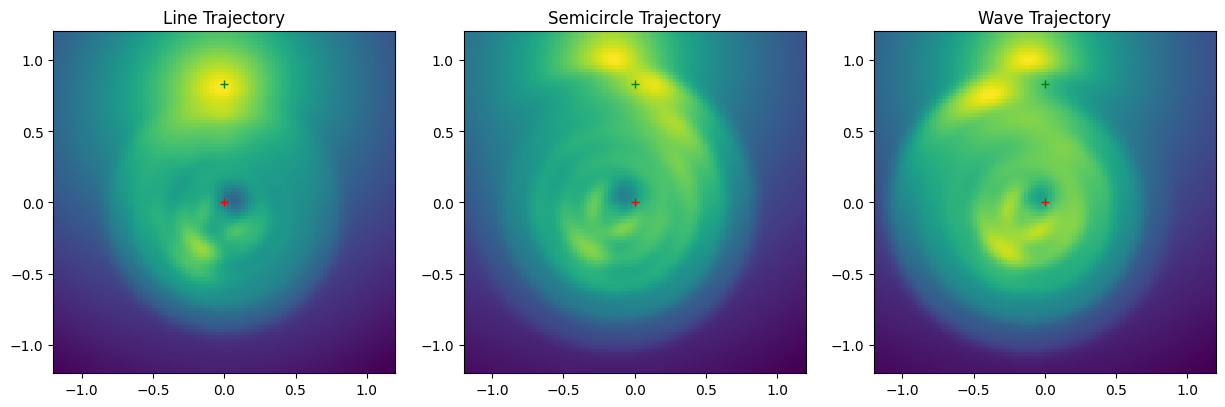

In [ ]:
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

fig, ax = plt.subplots(1, 3, figsize=(15, 5))

line_filtered = gaussian_filter(np.log(line_energy_field), sigma=2)
ax[0].imshow(line_filtered, cmap="viridis_r", extent = [-1.2, 1.2, -1.2, 1.2], origin="lower")
ax[0].plot(*line_start, "r+")
ax[0].plot(*line_end, "g+")
ax[0].set_title("Line Trajectory")

semicircle_filtered = gaussian_filter(np.log(semicircle_energy_field), sigma=2)
ax[1].imshow(semicircle_filtered, cmap="viridis_r", extent = [-1.2, 1.2, -1.2, 1.2], origin="lower")
ax[1].plot(*line_start, "r+")
ax[1].plot(*line_end, "g+")
ax[1].set_title("Semicircle Trajectory")

wave_filtered = gaussian_filter(np.log(wave_energy_field), sigma=2)
ax[2].imshow(wave_filtered, cmap="viridis_r", extent = [-1.2, 1.2, -1.2, 1.2], origin="lower")
ax[2].plot(*line_start, "r+")
ax[2].plot(*line_end, "g+")
ax[2].set_title("Wave Trajectory")

fig.show()

In [ ]:
# run optimization

corr_k = 0.002

for g in opt.param_groups:
    g['lr'] = 0.075
from torch.optim.lr_scheduler import ExponentialLR
scheduler = ExponentialLR(opt, gamma = 0.9999)

losses_viz = []
opt_iterations = 500 #overwrites

pcd_traj_list = {}
for i in range(opt_iterations):
    T_mat = torch_util.angle_axis_to_rotation_matrix(rot).squeeze()
    noise_vec = (torch.randn(X.size()) * (perturb_scale / ((i+1)**(perturb_decay)))).to(dev)
    X_perturbed = X + noise_vec
    X_new = torch_util.transform_pcd_torch(X_perturbed, T_mat) + trans[:, None, :].repeat((1, X.size(1), 1))
    X_new = torch.cat((X_new, torch.from_numpy(np.asarray(place_pts[None,:,:])).float().to(dev)), 0)
    
    
    
    corr_loss = torch.norm((torch.mean(X_new, 1) -  torch.mean(ref_query_traj, 1)), dim=0) 
    
    corr_loss = corr_loss *  torch.arange(1,corr_loss.shape[0]+1).to(dev)

    corr_loss = torch.sum(corr_loss)


    act_hat = model.forward_latent(opt_latent, X_new)
    t_size = reference_traj_desc.size()


    loss = loss_fn(act_hat.view(t_size), reference_traj_desc) + corr_k * corr_loss
    
    if i % 100 == 0:
        losses_str = ['%f' % loss.item()]
        loss_str = ', '.join(losses_str)
        
        print("corr_loss: ", corr_loss)
        print(f'i: {i}, loss: {loss_str}')
    
    if i < 100:
        losses_viz.append(loss.item())

    loss_values.append(loss.item())
    opt.zero_grad()
    loss.backward()
    opt.step()

best_loss = loss
print('best loss: %f, best_idx: %d' % (best_loss, 0))

corr_loss:  tensor(2.3343, device='cuda:0', grad_fn=<SumBackward0>)
i: 0, loss: 0.016312
corr_loss:  tensor(0.6618, device='cuda:0', grad_fn=<SumBackward0>)
i: 100, loss: 0.005646
corr_loss:  tensor(0.7099, device='cuda:0', grad_fn=<SumBackward0>)
i: 200, loss: 0.005760
corr_loss:  tensor(0.6722, device='cuda:0', grad_fn=<SumBackward0>)
i: 300, loss: 0.005672
corr_loss:  tensor(0.6965, device='cuda:0', grad_fn=<SumBackward0>)
i: 400, loss: 0.005685
best loss: 0.005665, best_idx: 0


In [ ]:
best_X = X_new.detach().cpu().numpy()

In [ ]:
offset = np.array([1, 0, 0])
vpcd1 = copy.deepcopy(pcd1)
vquery1 = copy.deepcopy(reference_query_pts)
vquery1_arr = copy.deepcopy(reference_query_pts_arr)

vpcd1 += offset
vquery1 += offset
vquery1_arr = [vq + offset for vq in vquery1_arr]



trans_best, rot_best = trans[0], rot[0]
transform_mat_np = torch_util.angle_axis_to_rotation_matrix(rot_best.view(1, -1)).squeeze().detach().cpu().numpy()
transform_mat_np[:-1, -1] = trans_best.detach().cpu().numpy()
rand_mat_np = rand_mat_init[best_idx].detach().cpu().numpy() 


frame1_tf = np.eye(4)
frame1_tf[:-1, -1] = (q_offset + offset)
frame2_tf = np.matmul(transform_mat_np, rand_mat_np)

frame1 = plotly_create_local_frame(transform=frame1_tf)
frame2 = plotly_create_local_frame(transform=rand_mat_np)
frame3 = plotly_create_local_frame(transform=frame2_tf)
frame_data = frame1 + frame2 + frame3

x_arr = []
for i in range(n_poses):
  x_arr = x_arr + [best_X[i]] 

num_int_pts = 100
offs = np.append(np.arange(num_int_pts)/num_int_pts, 1)

traj = None

for i in range(n_poses-1):
  if traj is None:
    traj = np.mean(best_X[i], 0) + np.outer(offs, (np.mean(best_X[i+1], 0) -   np.mean(best_X[i],0)))
    print(traj.shape)   
  else:
    traj = np.append(traj,  np.mean(best_X[i], 0) + np.outer(offs, (np.mean(best_X[i+1], 0) -   np.mean(best_X[i],0))), axis=0)
traj = list(traj)


ref_traj = None

for i in range(n_poses-1):
  if ref_traj is None:
    ref_traj = np.mean(vquery1_arr[i], 0) + np.outer(offs, (np.mean(vquery1_arr[i+1], 0) -   np.mean(vquery1_arr[i],0)))
  else:
    ref_traj = np.append(ref_traj,  np.mean(vquery1_arr[i], 0) + np.outer(offs, (np.mean(vquery1_arr[i+1], 0) -   np.mean(vquery1_arr[i],0))), axis=0)
ref_traj = list(ref_traj)



plot3d(
    [vpcd1]+vquery1_arr+[pcd2]+ x_arr , 
    ['purple', 'black', 'blue']+['blue' for _ in range(2*len(vquery1_arr))]+['black' for _ in range(n_poses)], 
    osp.join(viz_path, 'best_alignment.html'),
    scene_dict=plotly_scene_dict,
    z_plane=False,
    extra_data=frame_data)

best_scene = None
if trimesh_viz:
    local_frame_1 = trimesh.creation.axis(origin_size=0.002, transform=frame1_tf, origin_color=None, axis_radius=None, axis_length=0.03)
      
    best_scene = trimesh_util.trimesh_show([vpcd1]+vquery1_arr+[pcd2]+ x_arr + [traj] + [ref_traj], show=False)
    best_scene.add_geometry([local_frame_1])

(101, 3)


In [ ]:
best_scene.show()